In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/control/"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "Kenyon_Control.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "Kenyon_Control_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "Kenyon_Control_anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "Kenyon_Control_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'Kenyon_Control_scenic_integrated-output.loom'

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

-----
anndata     0.8.0
scanpy      1.9.3
-----
MulticoreTSNE       NA
PIL                 9.5.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.1
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.2
dask                2022.02.0
dateutil            2.8.2
decorator           5.1.1
fsspec              2023.1.0
h5py                3.8.0
ipykernel           5.5.5
ipython_genutils    0.2.0
jedi                0.19.0
jinja2              3.1.2
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.39.1
loompy              3.0.7
markupsafe          2.1.3
matplotlib          3.5.3
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
numba               0.56.4
numexpr             2.8.5
numpy               1.21.6
numpy_groupies      0.9.22
packaging           23.1
pandas              1.3.5
parso               0.8.3
pexpect             4.8.0
pickleshare         

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [5]:
louvain = adata.obs["integrated_snn_res.0.5"]

In [6]:
adata.obs["louvain"] = louvain

In [7]:
# read in the embedding files from Seurat
pca = pd.read_csv('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/embedding_files/pca_control.csv')
umap = pd.read_csv('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/embedding_files/umap_control.csv')
PC1 = pca["PC_1"]
PC2 = pca["PC_2"]
PC3 = pca["PC_3"]
PC4 = pca["PC_4"]
PC5 = pca["PC_5"]
PC6 = pca["PC_6"]
PC7 = pca["PC_7"]
PC8 = pca["PC_8"]
PC9 = pca["PC_9"]
PC10 = pca["PC_10"]
PC11 = pca["PC_11"]
PC12 = pca["PC_12"]
PC13 = pca["PC_13"]
PC14 = pca["PC_14"]
PC15 = pca["PC_15"]
X_pca = np.stack([PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15]).T
UMAP1 = umap["UMAP_1"]
UMAP2 = umap["UMAP_2"]
X_umap = np.stack([UMAP1, UMAP2]).T
adata.obsm['X_umap'] = X_umap
adata.obsm['X_pca'] = X_pca

In [8]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  15262.242
Number of cells in which each gene is detected: 0  -  2440


In [9]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  73.5
minSamples:  24.5


In [10]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('mt:')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':
/home/acicalo/mini

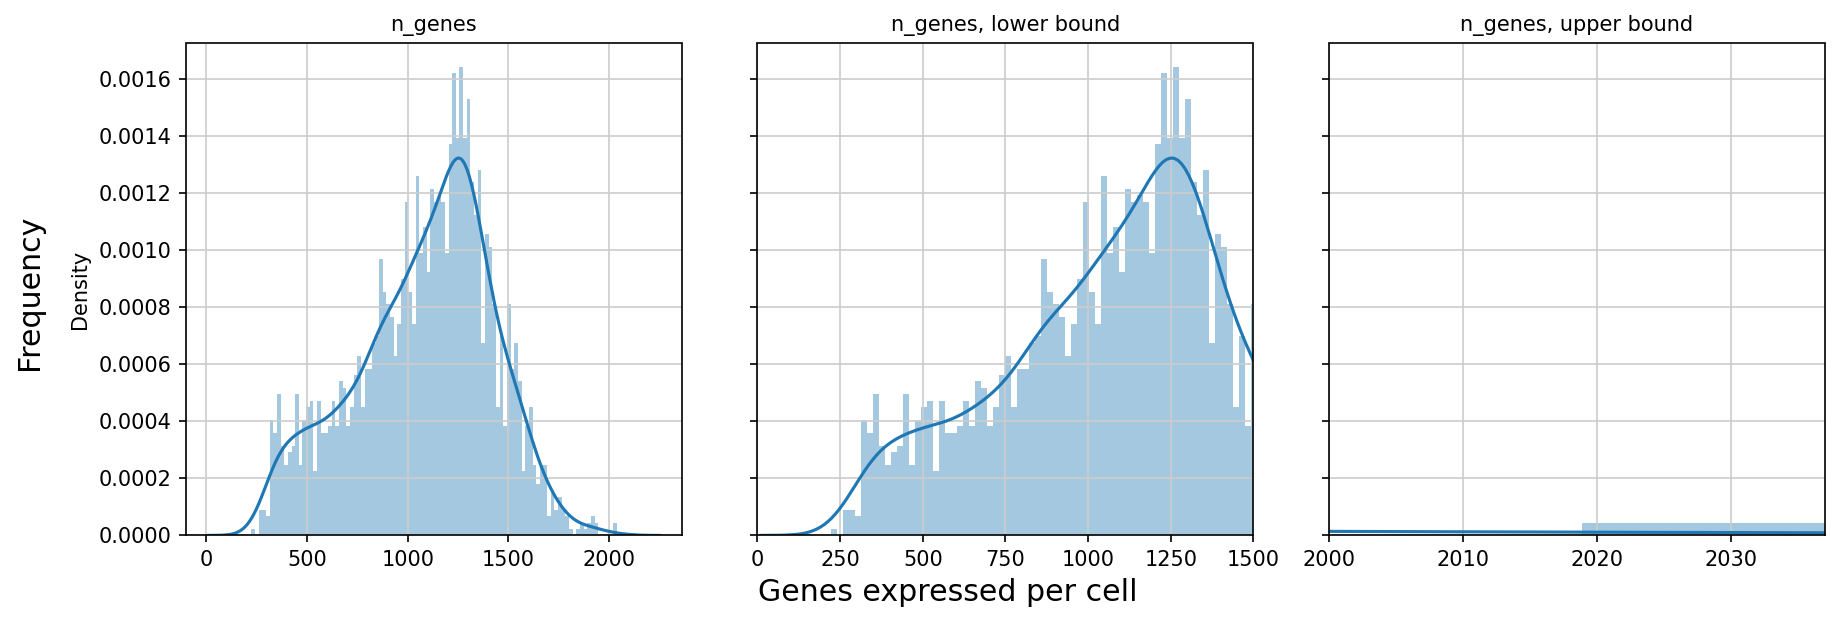

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD f

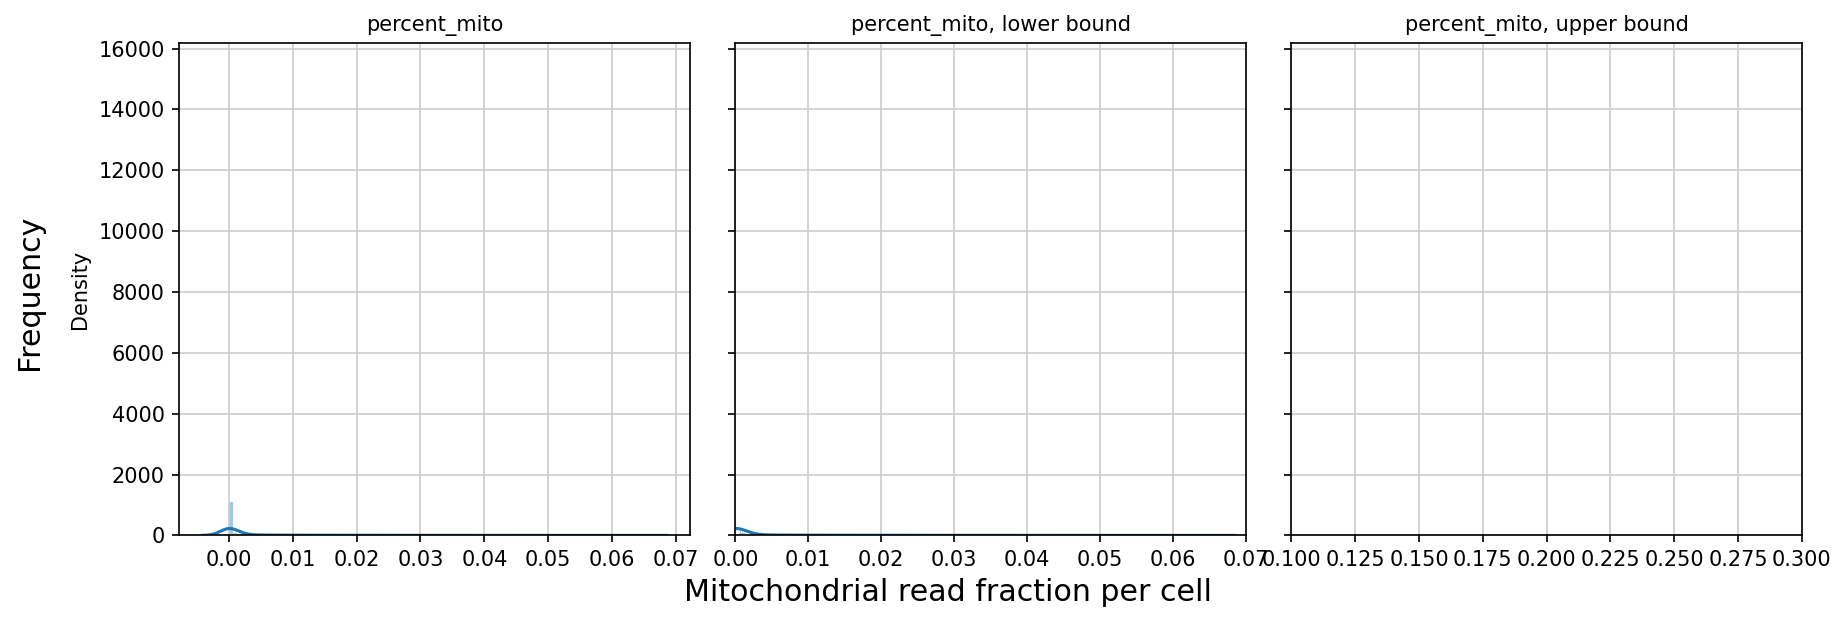

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de

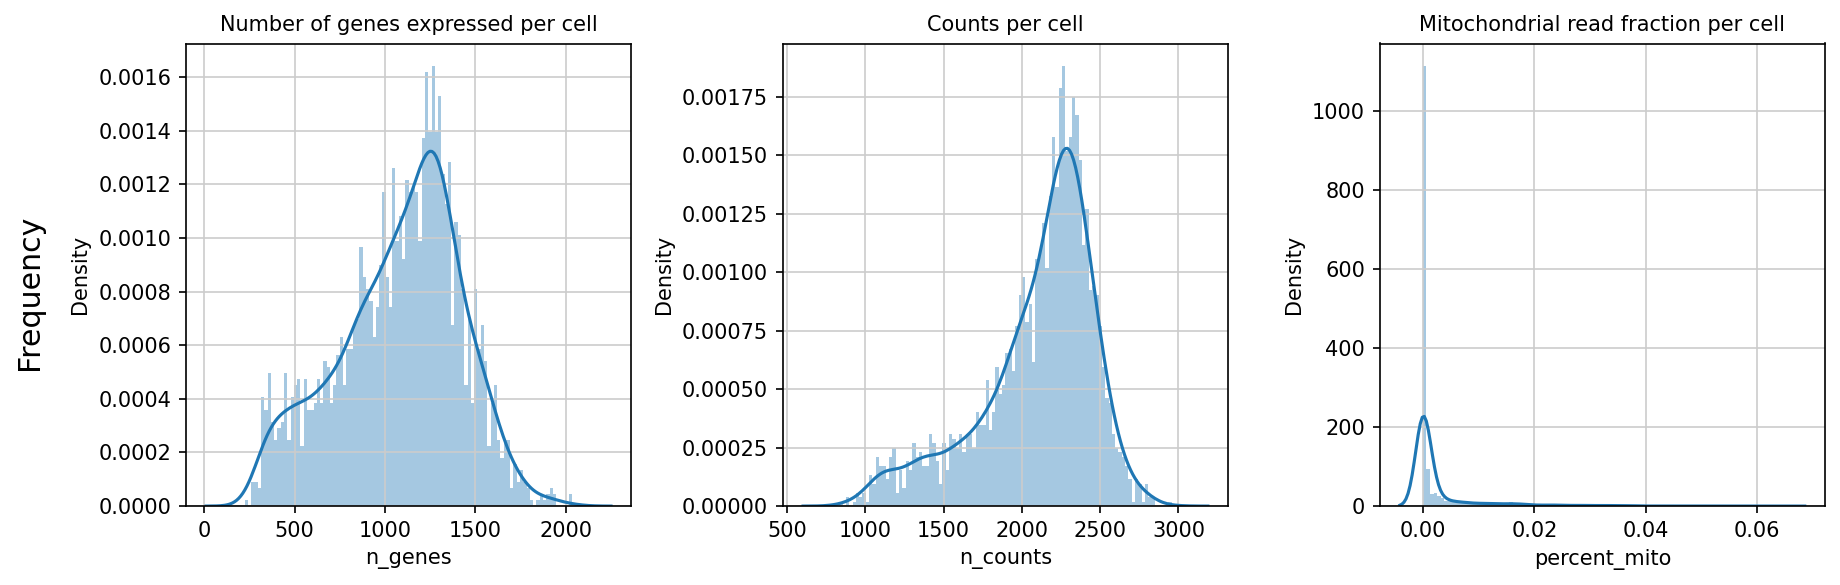

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

In [14]:
adata.var.index.is_unique

True

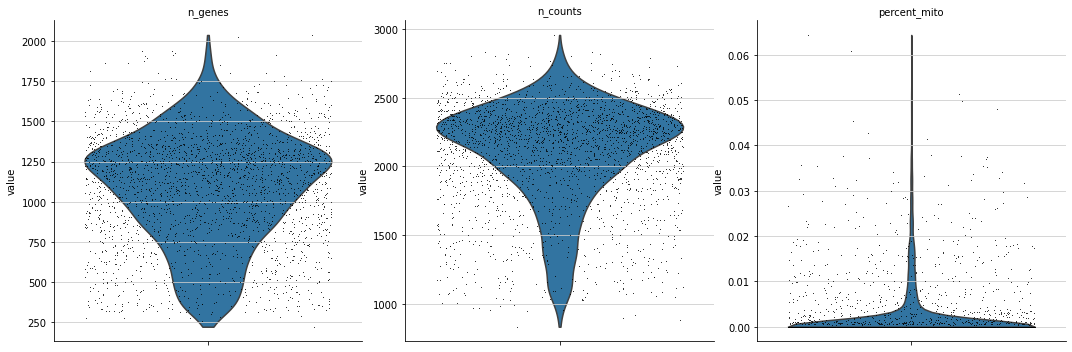

In [15]:

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

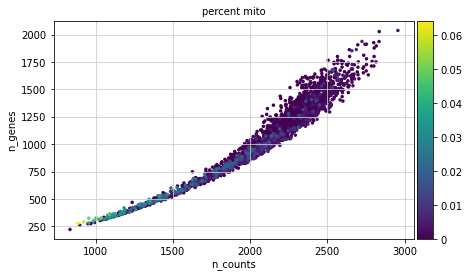

In [16]:

sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [17]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 6929 genes that are detected in less than 3 cells


In [18]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
/home/acicalo/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/acicalo/miniconda3/envs/pyscenic/li

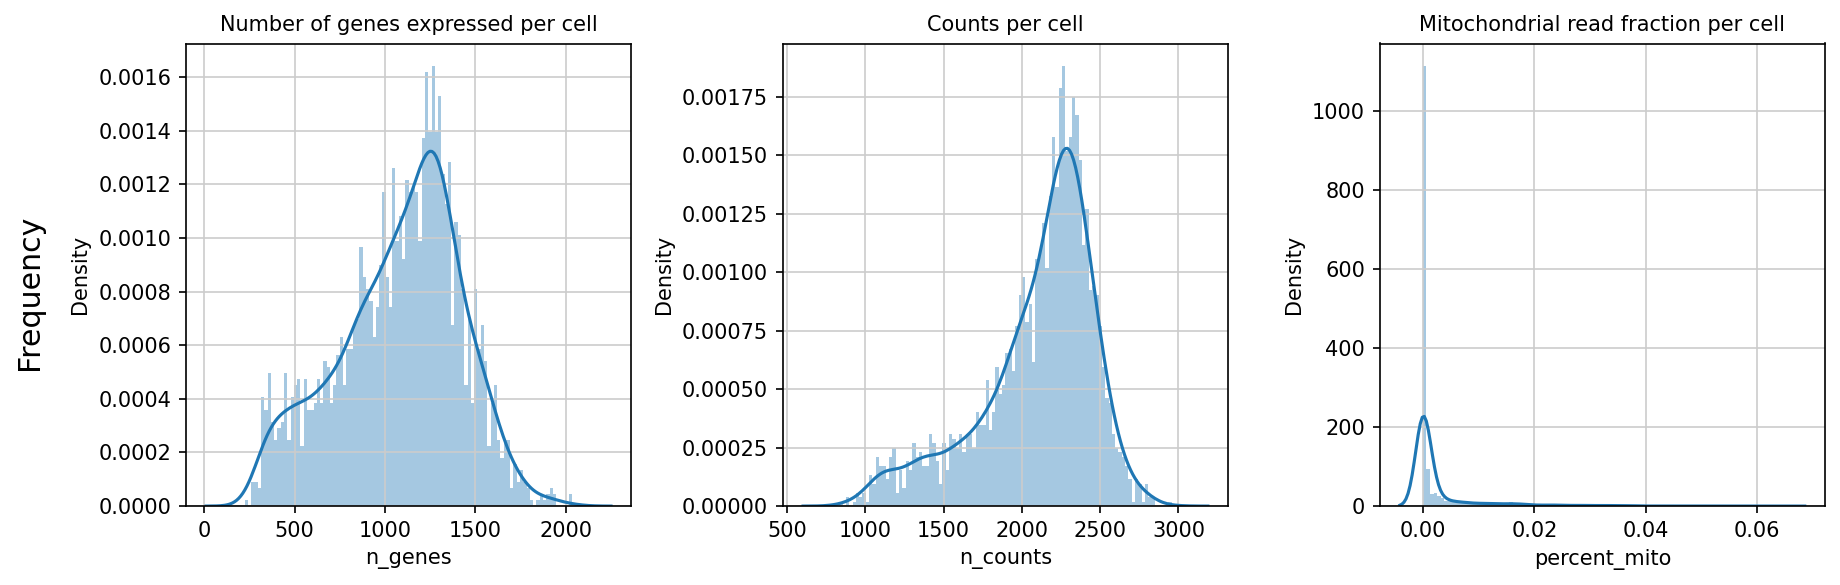

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

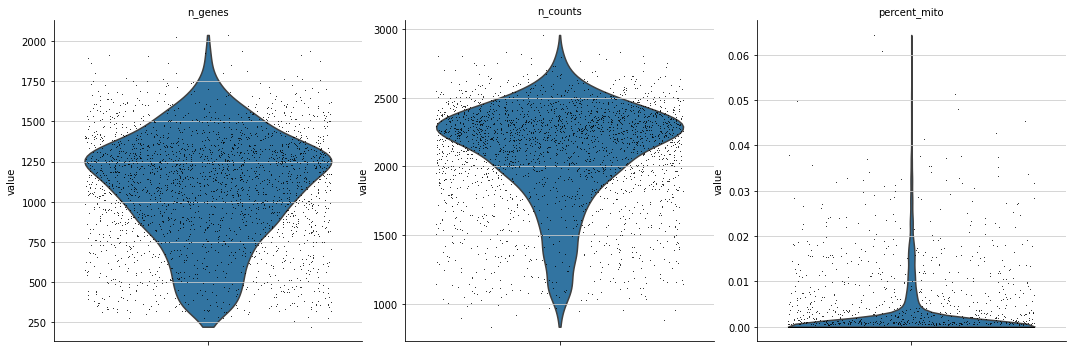

In [20]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

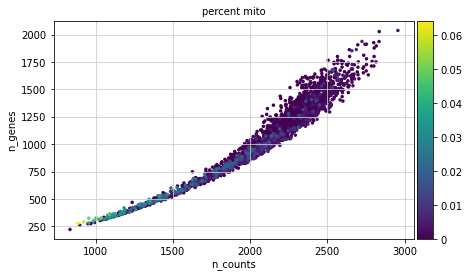

In [21]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [22]:
f_anndata_path

'Kenyon_Control_anndata.h5ad'

In [23]:
adata.write( f_anndata_path )

In [24]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


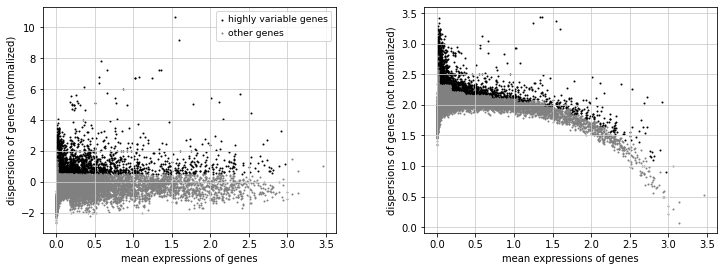

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [25]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

In [26]:
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

In [27]:
# transcription factors list
#f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt" # human
f_tfs = "/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/tf_list/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [28]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o /mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/control/control_adj.csv --num_workers 36



2023-09-11 16:34:58,165 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-09-11 16:34:58,479 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.


In [31]:
# read in adjacency matrix 
adjacencies = pd.read_csv("/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/control/control_adj.csv", index_col=False)

In [32]:
adjacencies.head()

,TF,target,importance
0,pros,mamo,180.801164
1,Hr38,sr,108.499727
2,mamo,Cngl,104.515486
3,jim,mamo,103.545537
4,mamo,Rbp6,101.281884


In [33]:
import glob
# ranking databases
f_db_glob = "/mnt/data0/CisTarget/drosophila_melanogaster/dm6/rankings/dm6_v10_clust.genes_vs_motifs.rankings.feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/mnt/data0/CisTarget/drosophila_melanogaster/dm6/annotations/motifs-v10nr_clust-nr.flybase-m0.001-o0.0.tbl"

In [34]:
!pyscenic ctx /mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/control_2/control_adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output /mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/control_2/control_reg.csv \
    --mask_dropouts \
    --num_workers 100


2023-09-06 16:14:53,303 - pyscenic.cli.pyscenic - INFO - Creating modules.

2023-09-06 16:14:53,609 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-09-06 16:14:53,951 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-09-06 16:14:54,074 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2023-09-06 16:14:56,956 - pyscenic.utils - INFO - Creating modules.

2023-09-06 16:15:32,901 - pyscenic.cli.pyscenic - IN

In [35]:
nGenesDetectedPerCellbefore = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.DataFrame(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

           0
0.01  134.49
0.05  161.00
0.10  176.00
0.50  231.00
1.00  756.00


/home/acicalo/miniconda3/envs/scenic/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


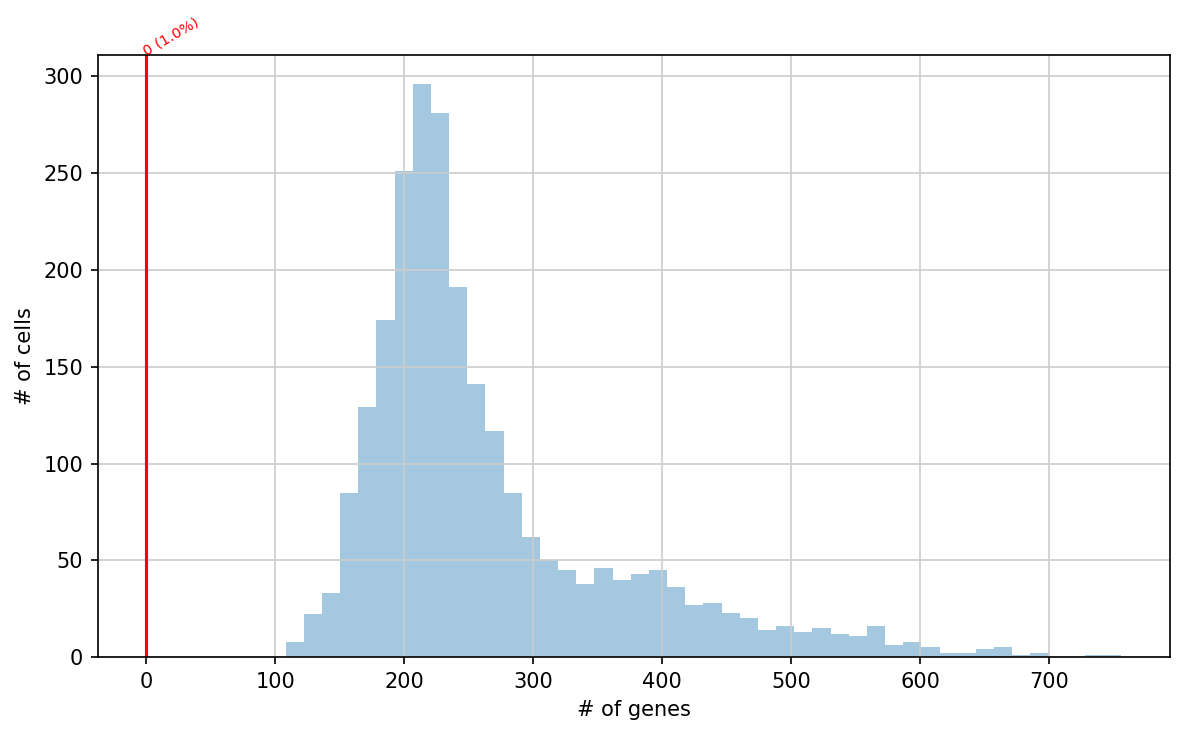

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [37]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    /mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/control_2/control_reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 100


2023-09-06 16:17:35,355 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-09-06 16:17:35,645 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2023-09-06 16:17:35,737 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-09-06 16:17:41,656 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [38]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [39]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

/home/acicalo/miniconda3/envs/scenic/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###


In [41]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/home/acicalo/miniconda3/envs/scenic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [42]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [43]:
cellid = lf.ca.CellID
cellid = np.asarray(cellid)
pd.DataFrame(cellid).to_csv('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/garnett/control_cellid.csv')

In [44]:

cellid

array(['AAAGTCCAGTTACGGG-1_1', 'AAAGTCCCAAGACGGT-1_1',
       'AAAGTGACACCAGCCA-1_1', ..., 'TTTGGTTCACCTGCGA-1_5',
       'TTTGTTGCATGAAGGC-1_5', 'TTTGTTGGTCAGCGTC-1_5'], dtype=object)

In [45]:
garnett = pd.read_csv( '/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/garnett/Kenyon_Control_garnett_results.csv', index_col=0)
garnett.head()
garnett["cell_type"]

1       Kenyon
2       Kenyon
3       Kenyon
4       Kenyon
5       Kenyon
         ...  
2446    Kenyon
2447    Kenyon
2448    Kenyon
2449    Kenyon
2450    Kenyon
Name: cell_type, Length: 2450, dtype: object

In [46]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": "highly variable genes UMAP"
    },
    {
        "id": 1,
        "name": "highly variable genes t-SNE"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(str) ))
    },
    {
        "name": "Celltype_Garnett",
        "values": list(set( garnett["cell_type"].astype(str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

In [47]:
# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [48]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [49]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    "Celltype_Garnett": np.array( garnett['cell_type'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'dm6',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [50]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

In [51]:
f_final_loom

'Kenyon_Control_scenic_integrated-output.loom'